In [169]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

In [170]:
# # Uncomment this to load data from downloaded tar.gz archive.
# # change this path
PATH_TO_IMDB = '../practical/aclImdb/'
reviews_train = load_files(os.path.join(PATH_TO_IMDB, "train"),
                           categories=['pos', 'neg'])
text_train, y_train = reviews_train.data, reviews_train.target
# # change the path to the file
reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"),
                         categories=['pos', 'neg'])
text_test, y_test = reviews_test.data, reviews_test.target

In [171]:
print("number of documents in training data: %d "% len(text_train))
print(np.bincount(y_train))
print("number of documents in test data: %d "% len(text_test))
print(np.bincount(y_test))

number of documents in training data: 25000 
[12500 12500]
number of documents in test data: 25000 
[12500 12500]


In [172]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [173]:
print(y_train[1])

0


In [174]:
cv=CountVectorizer()
cv.fit(text_train)
len(cv.vocabulary_)

74849

In [175]:
print(cv.get_feature_names()[:50])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']


In [176]:
X_train=cv.transform(text_train)

In [177]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [178]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562])

In [179]:
X_test=cv.transform(text_test)

In [180]:
%%time
logit=LogisticRegression(solver='lbfgs',n_jobs=-1,random_state=7)
logit.fit(X_train,y_train)

Wall time: 5.29 s


In [181]:
print(logit)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=7, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)


In [182]:
round(logit.score(X_train,y_train),3),round(logit.score(X_test,y_test),3)

(0.982, 0.863)

In [183]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coef=classifier.coef_.ravel()
    positive_coefficients=np.argsort(coef)[-n_top_features:]
    negative_coefficients=np.argsort(coef)[:n_top_features]
    interesting_coefficients=np.hstack([negative_coefficients,positive_coefficients])
    plt.figure(figsize=(15,5))
    colors=['red' if c<0 else 'blue' for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");
    
    

In [184]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'], color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'], color='red', label='test')
    plt.legend()    

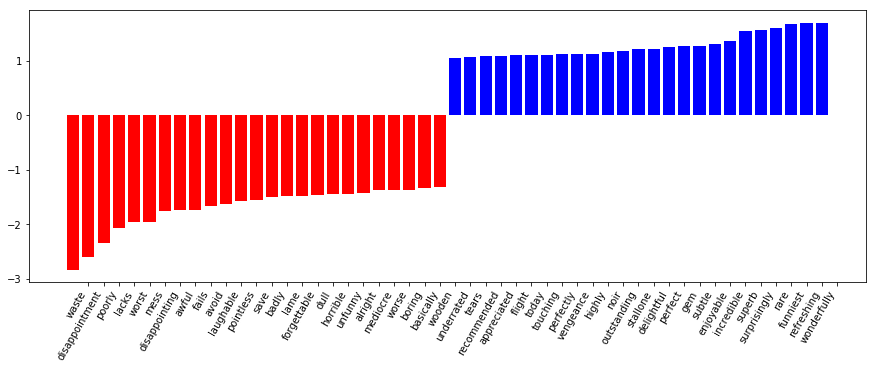

In [185]:
visualize_coefficients(logit,cv.get_feature_names())

In [186]:
%%time
from sklearn.pipeline import make_pipeline
text_pipe_logit=make_pipeline(CountVectorizer(), 
                              LogisticRegression(solver='lbfgs',n_jobs=1,random_state=7))
text_pipe_logit.fit(text_train,y_train)
print(text_pipe_logit.score(text_test,y_test))

0.86396
Wall time: 13.5 s


In [188]:
%%time
from sklearn.model_selection import GridSearchCV
param_grid_logit={'logisticregression__C':np.logspace(-5,0,6)}
grid_logit= GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=1)
grid_logit.fit(text_train, y_train)


Wall time: 2min 40s


In [189]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.88484)

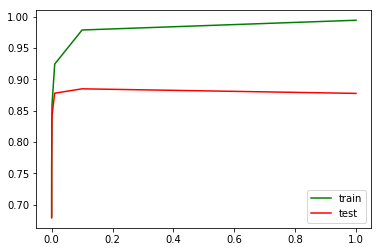

In [190]:
plot_grid_scores(grid_logit, 'logisticregression__C')

In [191]:
grid_logit.score(text_test, y_test)

0.87812

In [192]:
from sklearn.ensemble import RandomForestClassifier

In [193]:
forest= RandomForestClassifier(n_estimators=200, n_jobs=-1,random_state=17)

In [194]:
%%time
forest.fit(X_train, y_train)

Wall time: 36.2 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [195]:
round(forest.score(X_test, y_train), 3)

0.855

In [196]:
rng= np.random.RandomState(0)
X=rng.randn(200,2)
y= np.logical_xor(X[:,0]>0, X[:,1]>0)

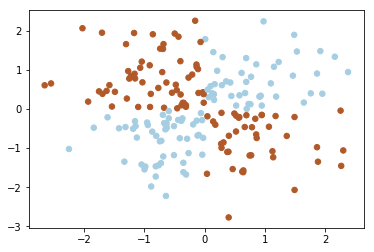

In [197]:
plt.scatter(X[:,0], X[:,1], s=30, c=y, cmap=plt.cm.Paired);

In [198]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

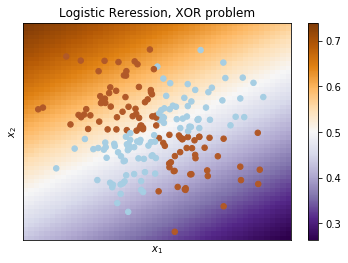

In [199]:
plot_boundary(LogisticRegression(), X, y, "Logistic Reression, XOR problem")

In [202]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [204]:
logit_pipe= Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression())])

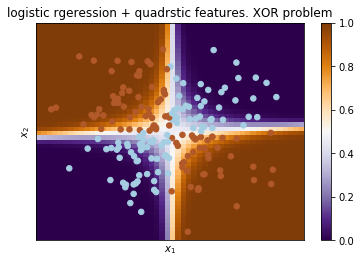

In [206]:
plot_boundary(logit_pipe, X,y, "logistic rgeression + quadrstic features. XOR problem")